# 1 Введение

## 1.1 Постановка задачи

**Заказчик** -- cервис по продаже автомобилей с пробегом  
  
**Задача** -- построить модель для определения стоимости автомобилей, которая будет использоваться в приложении для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.
  
Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

## 1.2 Исходные данные

### 1.2.1 Общее описание
В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

### 1.2.2 Переданные файлы
- autos.csv

### 1.2.3 Описание данных
**Признаки**  
- *DateCrawled* — дата скачивания анкеты из базы;
- *VehicleType* — тип автомобильного кузова;
- *RegistrationYear* — год регистрации автомобиля;
- *Gearbox* — тип коробки передач;
- *Power* — мощность (л. с.);
- *Model* — модель автомобиля;
- *Kilometer* — пробег (км);
- *RegistrationMonth* — месяц регистрации автомобиля;
- *FuelType* — тип топлива;
- *Brand* — марка автомобиля;
- *NotRepaired* — была машина в ремонте или нет;
- *DateCreated* — дата создания анкеты;
- *NumberOfPictures* — количество фотографий автомобиля;
- *PostalCode* — почтовый индекс владельца анкеты (пользователя);
- *LastSeen* — дата последней активности пользователя.
  
**Целевой признак**
- *Price* — цена (евро).

## 1.3 План обработки и анализа данных

### 1.3.1 Предобработка данных
- обзор данных;
- корректировка имён столбцов (при необходимости);
- обнаружение и удаление пропусков:
 - выявить пропуски;
 - проанализировать причины их появления;
 - заполнить пропуски (приняв решение по алгоритму заполнения), либо удалить их;
- преобразование типов данных столбцов (при необходимости);
- поиск и исправление ошибок (аномальных значений) в данных;
- удаление дубликатов строк;
- провести прямое кодирование категориальных признаков (при необходимости);
- разбиение данных на обучающую и тестовые выборки, выделение целового признака.

### 1.3.2 Обучение различных моделей
Обучить модели:
- *Линейной регрессии*;
- *LightGBM*;
- *CatBoost*.

### 1.3.3 Анализ скорости работы и качества полученных моделей
Для оценки качества моделей применить метрику *RMSE*

### 1.3.6 Вывод

## 1.4 Пользовательские функции

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 10
#pd.options.display.max_columns = 50
pd.options.mode.chained_assignment = None

In [2]:
def hist(col, label, bins=100, figsize=(16,5), xlim=None):
    '''
    Функция отрисовки гистограммы с линией распределения плотности вероятности и с boxplot-ом
    '''
    
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.set(style="whitegrid")
    sns.distplot(data[col], ax=ax, bins=bins, axlabel=label)
    
    ax2 = ax.twinx()
    sns.boxplot(x=data[col], ax=ax2)
    ax2.set(ylim=(-.5, 10))
    
    plt.axvline(data[col].mean(), color='green', linestyle='dashed', linewidth=2)
    tx = "mean: {:.2f}".format(data[col].mean())
    _, tx_x = plt.xlim()
    _, tx_y = plt.ylim()
    plt.text(data[col].mean()+tx_x/100, tx_y-5*tx_y/100, tx)
    
    if xlim:
        ax.set(xlim=xlim)

In [3]:
def RMSE(target_valid, predicted_valid):
    '''
    Функция расчёта RMSE
    '''
    
    return mean_squared_error(target_valid, predicted_valid) ** 0.5

# 2 Основная часть

## 2.1 Предобработка данных

**Обзор данных**

In [4]:
data = pd.read_csv('autos.csv')

In [5]:
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Прежде, чем проводить дальнейшую предобработку, удалим из рассмотрения столбцы данных не представляющих для нас интереса, а именно:
- *DateCrawled* — дата скачивания анкеты из базы;
- *RegistrationMonth* — месяц регистрации автомобиля;
- *DateCreated* — дата создания анкеты;
- *NumberOfPictures* — количество фотографий автомобиля;
- *PostalCode* — почтовый индекс владельца анкеты (пользователя); по хорошему -- по почтовым индексам необходимо было бы определить регион, в котором продаётся автомобиль, потому что Toyota во Владивостоке будет отличаться в цене от аналогичной в Москве; однако по переданным данным нам не удасться восстановить регион пользователя;
- *LastSeen* — дата последней активности пользователя.

In [7]:
data = data.drop(columns=['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'],
                 axis='columns')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
Price               354369 non-null int64
VehicleType         316879 non-null object
RegistrationYear    354369 non-null int64
Gearbox             334536 non-null object
Power               354369 non-null int64
Model               334664 non-null object
Kilometer           354369 non-null int64
FuelType            321474 non-null object
Brand               354369 non-null object
NotRepaired         283215 non-null object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [9]:
data.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
NotRepaired         71154
dtype: int64

In [10]:
data_amount = data.shape[0] * data.shape[1]
nan_amount = data.isna().sum().sum()
print('Объем пропусков от общего объема данных -- {:.2%}'.format(nan_amount / data_amount))

Объем пропусков от общего объема данных -- 5.11%


In [11]:
data_whithout_nan = data.copy()
data_whithout_nan.dropna(inplace = True)
data_whithout_nan_amount = data_whithout_nan.shape[0] * data_whithout_nan.shape[1]
print('При удалении пропусков будет удалено {:.2%} данных'.format((data_amount - data_whithout_nan_amount - nan_amount)
                                                                   / data_amount))

При удалении пропусков будет удалено 25.52% данных


По итогам первого, общего взгляда на данные, можно сделать следующие выводы:

- набор данных состоит из 10 столбцов и 354369 строк;
- имена столбцов читабельны, но требуют приведения их к привычному виду ("under_score" нотации)]; вероятнее всего имя столбца *NotRepaired* не соответствувет данным, хранящимся в нём; столбец необходимо переименовать в *repaired*;
- объем пропусков сравнительно невелик, но при их удалении будет удален значительный объем данных -- более 25%; поэтому, по возможности, пропуски необходимо заполнить;
-  поскольку объем пропусков невелик, будем заполнять их на наиболее часто встречающиеся значения, как наиболее вероятные; пропуски имеются в данных столбцов:
 - *VehicleType*, *Gearbox*, *Model*, *FuelType*;
 - *NotRepaired* -- была машина в ремонте или нет, поэтому пропуск будем воспринимать, как отстутствие ремонта, т.е. равным значению _"no"_.

**Корректировка имён столбцов**

In [12]:
data.rename(columns={'Price': 'price',
                     'VehicleType': 'vehicle_type',
                     'RegistrationYear': 'registration_year',
                     'Gearbox': 'gearbox',
                     'Power': 'power',
                     'Model': 'model',
                     'Kilometer': 'kilometer',
                     'FuelType': 'fuel_type',
                     'Brand': 'brand',
                     'NotRepaired': 'repaired',},
            inplace=True)

data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

**Заполнение пропусков**

In [13]:
data['repaired'].fillna('no', inplace=True)

In [14]:
data['vehicle_type'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

In [15]:
data['vehicle_type'].fillna('sedan', inplace=True)

In [16]:
data['gearbox'].value_counts()

manual    268251
auto       66285
Name: gearbox, dtype: int64

In [17]:
data['gearbox'].fillna('manual', inplace=True)

In [18]:
data['model'].value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

In [19]:
data['model'].fillna('other', inplace=True)

In [20]:
data['fuel_type'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [21]:
data['fuel_type'].fillna('petrol', inplace=True)

In [22]:
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

**Поиск и исправление ошибок (аномальных значений)**

*Признак* ***price***

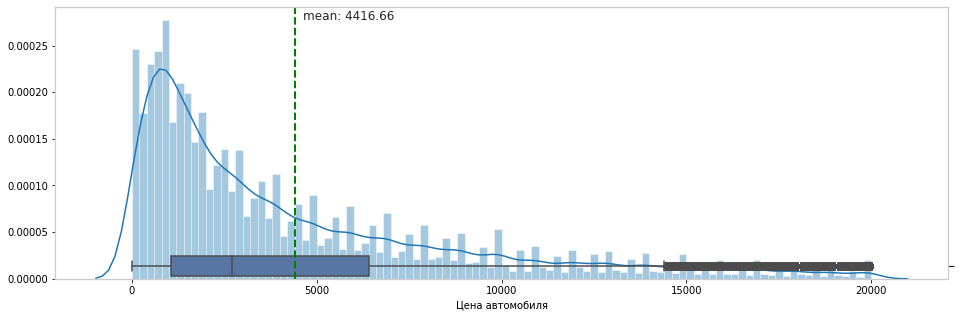

In [23]:
hist('price', 'Цена автомобиля')

In [24]:
data['price'].describe()

count   354369.00
mean      4416.66
std       4514.16
min          0.00
25%       1050.00
50%       2700.00
75%       6400.00
max      20000.00
Name: price, dtype: float64

Аномальными значениями в признаке *price* являются нулевые значения. Поскольку восстановить их крайне затруднительно, удалим их

In [25]:
data = data.loc[data['price'] > 0, :]

*Признак* ***registration_year***

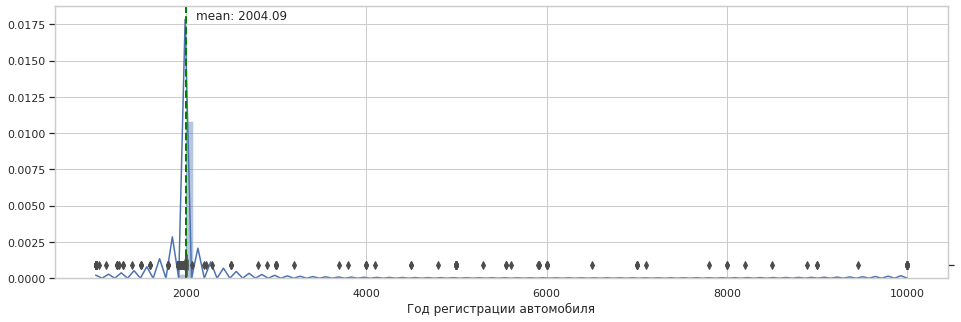

In [26]:
hist('registration_year', 'Год регистрации автомобиля')

In [27]:
data['registration_year'].describe()

count   343597.00
mean      2004.09
std         78.41
min       1000.00
25%       1999.00
50%       2003.00
75%       2008.00
max       9999.00
Name: registration_year, dtype: float64

In [28]:
print(sorted(data['registration_year'].unique()))

[1000, 1001, 1039, 1111, 1234, 1255, 1300, 1400, 1500, 1600, 1602, 1800, 1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 6500, 7000, 7100, 7800, 8000, 8200, 8500, 8888, 9000, 9450, 9999]


Аномальные значения в признаке находятся ниже значения 1910 и выше 2019. Удалим их, поскольку восстановить их крайне затруднительно, а год регистрации автомобиля оказывает сильное влияние на цену автомобиля

In [29]:
data = data.loc[(data['registration_year'] >= 1910) & (data['registration_year'] <= 2019), :]

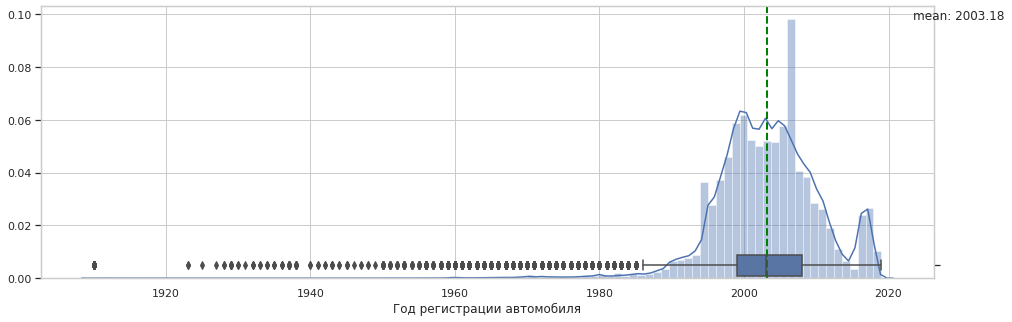

In [30]:
hist('registration_year', 'Год регистрации автомобиля')

*Признак* ***power***

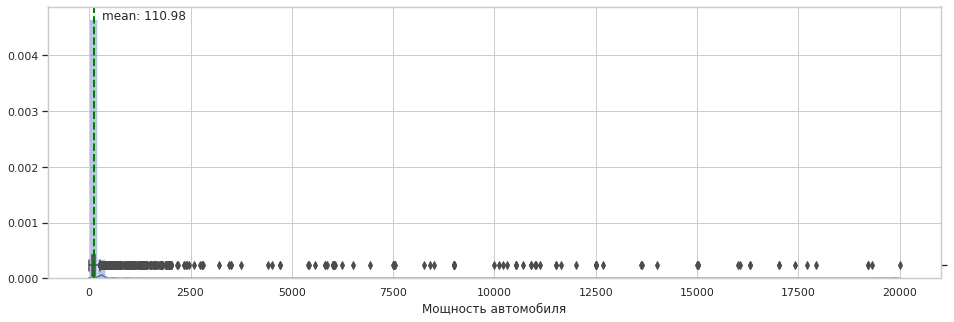

In [31]:
hist('power', 'Мощность автомобиля')

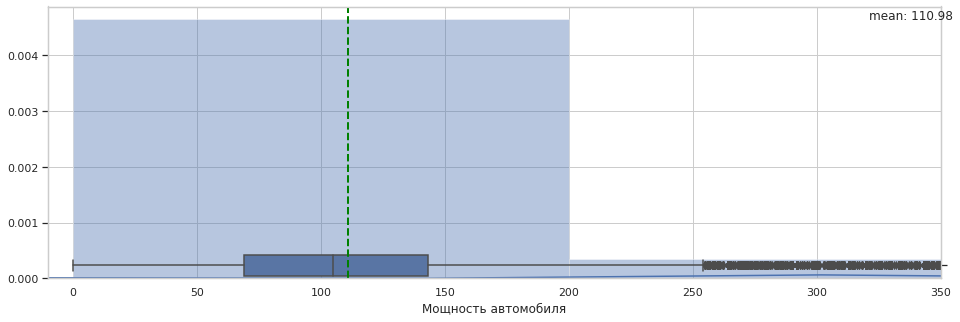

In [32]:
hist('power', 'Мощность автомобиля', xlim=(-10, 350))

In [33]:
data['power'].describe()

count   343458.00
mean       110.98
std        187.86
min          0.00
25%         69.00
50%        105.00
75%        143.00
max      20000.00
Name: power, dtype: float64

In [34]:
print(sorted(data['power'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

Выбранный диапазон дат регистрации автомобилей захватывает период с 1910-го года по наши дни, поэтому малые значения мощностей вполне допустимы -- мощность автомобиля, зарегистрированного в начале прошлого века, вполне могла быть равна 1 л.с. Аномальные максимальные значения (> 250 л.с.) удалим

In [35]:
data = data.loc[data['power'] <= 250, :]

In [36]:
print(sorted(data['power'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

Нулевые значения мощности автомобиля абсолютно алогичны. Удалим их

In [37]:
data = data.loc[data['power'] != 0, :]

*Признак* ***kilometer***

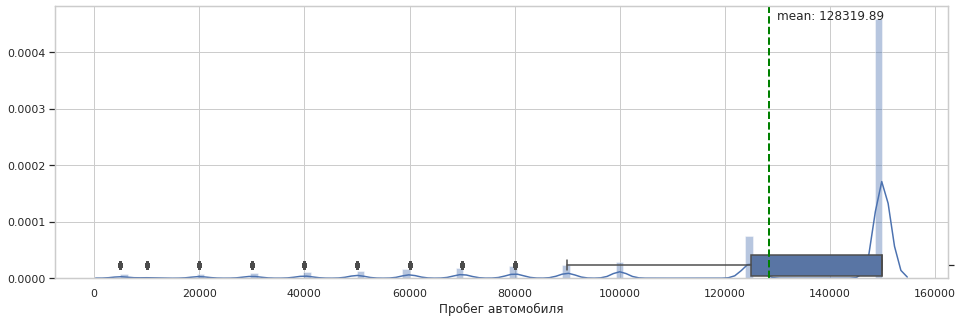

In [38]:
hist('kilometer', 'Пробег автомобиля')

In [39]:
print(sorted(data['kilometer'].unique()))

[5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 125000, 150000]


Признак предобработки не требует

**Удаление полных дубликатов строк**

In [40]:
data.duplicated().sum()

48566

In [41]:
data = data.drop_duplicates().reset_index(drop=True)

In [42]:
print('По итогам предобработки данных удалено {:.2f}% данных (вместе с пропусками)'.format(100 - 
                                                                                          ((data.shape[0] * data.shape[1]) /
                                                                                           data_amount)* 100))

По итогам предобработки данных удалено 29.06% данных (вместе с пропусками)


***Промежуточный итог***  
  
В ходе предобработки данных:
- удалены из рассмотрения столбцы данных не представляющих для нас интереса, а именно:
 - *DateCrawled* — дата скачивания анкеты из базы;
 - *RegistrationMonth* — месяц регистрации автомобиля;
 - *DateCreated* — дата создания анкеты;
 - *NumberOfPictures* — количество фотографий автомобиля;
 - *PostalCode* — почтовый индекс владельца анкеты (пользователя);
 - *LastSeen* — дата последней активности пользователя.
- скорректированы имена оставшихся столбцов;
- заполнены пропуски:
 - в столбце *NotRepaired* -- значениями *'no'*;
 - в столбцах *VehicleType*, *Gearbox*, *Model*, *FuelType* -- наиболее часто встречающимися значениями, как наиболее вероятными;
- удалены аномальные значения:
 - в признаке *price* -- нулевые значения;
 - в признаке *registration_year* -- значения ниже 1910 и выше 2019;
 - в признаке *power* -- нулевые значения <font color=Teal>и максимальные аномальные (> 250).
~~- были заменены значения мощностей признака *power* на медианные значения в группах, отсортированных по значениям признака *model*;~~</font>
- были удалены полные дубликаты строк.

## 2.2 Обучение различных моделей

### 2.2.1 Подготовка обучающей и валидационной выборок

In [43]:
from sklearn.preprocessing import OrdinalEncoder

cat_feats = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
num_feats = ['registration_year', 'power', 'kilometer']

features = data.drop(columns=['price'], axis='columns')
target = data['price']

encoder = OrdinalEncoder()
encoder.fit(features)

OE_features = pd.DataFrame(encoder.transform(features), columns=features.columns, index=features.index)

for i in cat_feats:
    OE_features[i] = OE_features[i].astype('int')
    
OHE_features = pd.get_dummies(data[cat_feats], drop_first=True)

for i in num_feats:
    OE_features[i] = data[i]
    OHE_features[i] = data[i]

OE_features_train, OE_features_valid, \
OHE_features_train, OHE_features_valid, \
target_train, target_valid = train_test_split(OE_features, OHE_features, target, test_size=0.25, random_state=1457)

### 2.2.2 Модель линейной регрессии

In [44]:
from sklearn.linear_model import LinearRegression

line_reg_model = LinearRegression()

In [45]:
%%time
line_reg_model.fit(OHE_features_train, target_train)

CPU times: user 13.6 s, sys: 4.16 s, total: 17.7 s
Wall time: 17.8 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### 2.2.3 Модель LightGBM

In [46]:
import lightgbm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

scorer = make_scorer(RMSE, greater_is_better = False)

lightgbm_model = lightgbm.LGBMRegressor()

params = {'num_leaves': [5,10,20],
          'learning_rate': [0.01, 0.1, 0.5, 1], 
          'n_estimators': [100]}

grid = GridSearchCV(estimator=lightgbm_model, param_grid = params, cv = 2, scoring=scorer)

grid.fit(OE_features_train, target_train)

print('Лучшее значение RMSE:', grid.best_score_)
print('Параметры при лучшем RMSE:', grid.best_params_)

Лучшее значение RMSE: -1696.6032066631021
Параметры при лучшем RMSE: {'learning_rate': 0.5, 'n_estimators': 100, 'num_leaves': 20}


In [47]:
%%time

lightgbm_model = lightgbm.LGBMRegressor(learning_rate=0.5, n_estimators=100, num_leaves=20)
lightgbm_model.fit(OE_features_train, target_train)

CPU times: user 5.13 s, sys: 26.7 ms, total: 5.16 s
Wall time: 5.2 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.5, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=20, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### 2.2.4 Модель CatBoost

In [48]:
from catboost import CatBoostRegressor

catboost_model = CatBoostRegressor(cat_features=cat_feats, n_estimators=100)

In [49]:
%%time

catboost_model.fit(OE_features_train, target_train)

0:	learn: 4445.3872098	total: 330ms	remaining: 32.7s
1:	learn: 4360.8040386	total: 539ms	remaining: 26.4s
2:	learn: 4281.4460430	total: 837ms	remaining: 27.1s
3:	learn: 4206.4504567	total: 1.13s	remaining: 27.1s
4:	learn: 4129.9754295	total: 1.34s	remaining: 25.4s
5:	learn: 4055.5321544	total: 1.63s	remaining: 25.5s
6:	learn: 3984.3494813	total: 1.83s	remaining: 24.4s
7:	learn: 3916.3889975	total: 2.13s	remaining: 24.5s
8:	learn: 3849.2670591	total: 2.33s	remaining: 23.6s
9:	learn: 3785.8022817	total: 2.63s	remaining: 23.6s
10:	learn: 3726.9397512	total: 2.83s	remaining: 22.9s
11:	learn: 3666.2081081	total: 3.12s	remaining: 22.9s
12:	learn: 3609.7395853	total: 3.33s	remaining: 22.3s
13:	learn: 3555.5909680	total: 3.62s	remaining: 22.2s
14:	learn: 3502.7138422	total: 3.83s	remaining: 21.7s
15:	learn: 3451.2159192	total: 4.04s	remaining: 21.2s
16:	learn: 3403.4390142	total: 4.32s	remaining: 21.1s
17:	learn: 3358.2334003	total: 4.53s	remaining: 20.6s
18:	learn: 3310.5899825	total: 4.82s	r

## 2.3 Анализ скорости работы и качества полученных моделей

***Константная модель***

In [50]:
%%time

predicted_valid = pd.Series(target_train.mean(), index=target_valid.index)

CPU times: user 2.85 ms, sys: 0 ns, total: 2.85 ms
Wall time: 1.61 ms


In [51]:
print('RMSE: {:.2f}'.format(RMSE(target_valid, predicted_valid)))

RMSE: 4545.55


***Логическая регрессия***

In [52]:
%%time

predicted_valid = line_reg_model.predict(OHE_features_valid)

CPU times: user 89.2 ms, sys: 85.5 ms, total: 175 ms
Wall time: 137 ms


In [53]:
print('RMSE: {:.2f}'.format(RMSE(target_valid, predicted_valid)))

RMSE: 2702.56


***Модель LightGBM***

In [54]:
%%time

predicted_valid = lightgbm_model.predict(OE_features_valid)

CPU times: user 424 ms, sys: 0 ns, total: 424 ms
Wall time: 413 ms


In [55]:
print('RMSE: {:.2f}'.format(RMSE(target_valid, predicted_valid)))

RMSE: 1671.38


***Модель CatBoost***

In [56]:
%%time

predicted_valid = catboost_model.predict(OE_features_valid)

CPU times: user 172 ms, sys: 10.9 ms, total: 183 ms
Wall time: 200 ms


In [57]:
print('RMSE: {:.2f}'.format(RMSE(target_valid, predicted_valid)))

RMSE: 2000.71


,Модель,RMSE,"Скорость обучения, с","Скорость предсказания, мс"
0,Константная,4545.55,0.00,1.96
1,Линейная Регрессия,2702.56,4.82,385.00
2,LightGBM,1671.38,1.55,232.00
3,CatBoost,1685.78,8.87,246.00


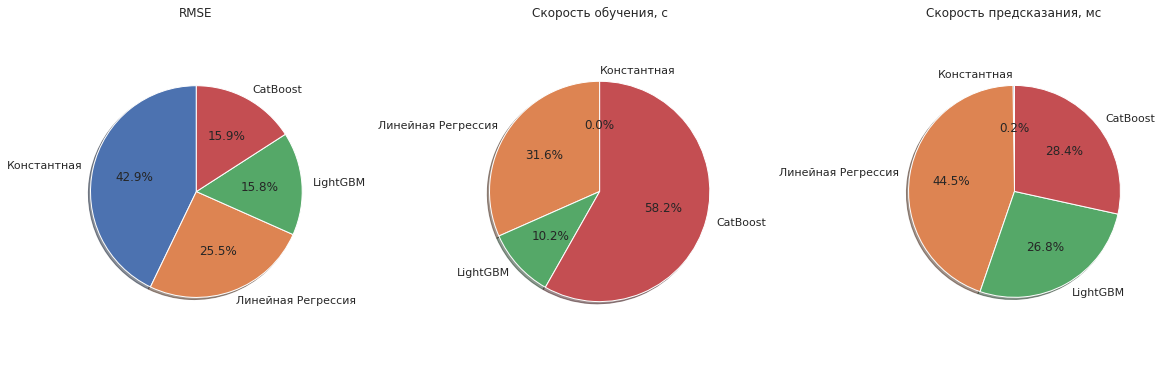

In [58]:
results = pd.DataFrame({'Модель': ['Константная', 'Линейная Регрессия', 'LightGBM', 'CatBoost'],
                        'RMSE': [4545.55, 2702.56, 1671.38, 1685.78],
                        'Скорость обучения, с': [0, 4.82, 1.55, 8.87],
                        'Скорость предсказания, мс':[1.96, 385, 232, 246]})

fig, axs = plt.subplots(1, 3, figsize=(16,5), constrained_layout=True)
cats = ['RMSE', 'Скорость обучения, с', 'Скорость предсказания, мс']
subplot = 0

for cat in cats:
    labels = results['Модель']
    rslts = results[cat].tolist()

    axs[subplot].pie(rslts, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    axs[subplot].axis('equal')
    axs[subplot].set_title(cat)

    subplot += 1

results

***Промежуточный итог***  
  
По итогам проведённого анализа можно сделать следующие выводы:

- лучшим качеством обладают модели *LightGBM* и *CatBoost*;
- наивысшую скорость обучения имеет модель *LightGBM*;
- с учётом предыдущих выводов, интерес для нас имеют модели *LightGBM* и *CatBoost*, скорость предсказания которых сопоставима.

# 3 Вывод

В ходе выполнения работы было сделано следующее.  
  
В ходе предобработки данных:
- были удалены из рассмотрения столбцы данных не представляющих для нас интереса, а именно:
 - *DateCrawled* — дата скачивания анкеты из базы;
 - *RegistrationMonth* — месяц регистрации автомобиля;
 - *DateCreated* — дата создания анкеты;
 - *NumberOfPictures* — количество фотографий автомобиля;
 - *PostalCode* — почтовый индекс владельца анкеты (пользователя);
 - *LastSeen* — дата последней активности пользователя.
- были скорректированы имена оставшихся столбцов;
- были заполнены пропуски:
 - в столбце *NotRepaired* -- значениями *'no'*;
 - в столбцах *VehicleType*, *Gearbox*, *Model*, *FuelType* -- наиболее часто встречающимися значениями, как наиболее вероятными;
- были удалены аномальные значения:
 - в признаке *price* -- нулевые значения;
 - в признаке *registration_year* -- значения ниже 1910 и выше 2019;
 - в признаке *power* -- нулевые значения и максимальные аномальные (> 250);
- были удалены полные дубликаты строк.
  
Затем были созданы и обучены модели *Линейной регрессии*, *LightGBM*, *CatBoost*.  
  
Затем полученные модели были исследованы на качество предсказаний и скорость выполнения данных предсказаний.  
По итогам проведённого анализа были сделаны следующие выводы:
- лучшим качеством обладают модели *LightGBM* и *CatBoost*;
- наивысшую скоорсть обучения имеет модель *LightGBM*;
- с учётом предыдущих выводов, интерес для нас имеют модели *LightGBM* и *CatBoost*, скорость предсказания которых сопоставима.
  
***Таким образом, по итогам выполнения работы и проведённого анализа можно сделать вывод, что наилучшей моделью по качеству предсказания, скорости предсказания и времени обучения является модель LightGBM, которую необходимо рекомендовать Заказчику***